In [1]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy


In [2]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"
    
    Excludes any file containing "br_raw" in its path and logs all skipped folders.
    
    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []
    
    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }
    
    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")
    
    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.
    
    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.
    
    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)
    
    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


In [4]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.
    
    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")
    
    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)
    
    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept
    
    return pixel_array, ds

In [5]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")

Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


Loading file for group PD: Images\PPMI_Images_PD\120544\Reconstructed_DaTSCAN\2023-01-11_13_16_30.0\I1671496\PPMI_120544_NM_Reconstructed_DaTSCAN_Br_20230228103816700_1_S1198040_I1671496.dcm
Loading file for group SWEDD: Images\PPMI_Images_SWEDD\3751\Reconstructed_DaTSCAN\2011-04-28_14_07_23.0\I339019\PPMI_3751_NM_Reconstructed_DaTSCAN_Br_20121009132100675_1_S127570_I339019.dcm
Loading file for group Control: Images\PPMI_Images_Cont\140451\Reconstructed_DaTSCAN\2022-02-10_12_13_54.0\I1548463\PPMI_140451_NM_Reconstructed_DaTSCAN_Br_20220224140249314_1_S1107918_I1548463.dcm


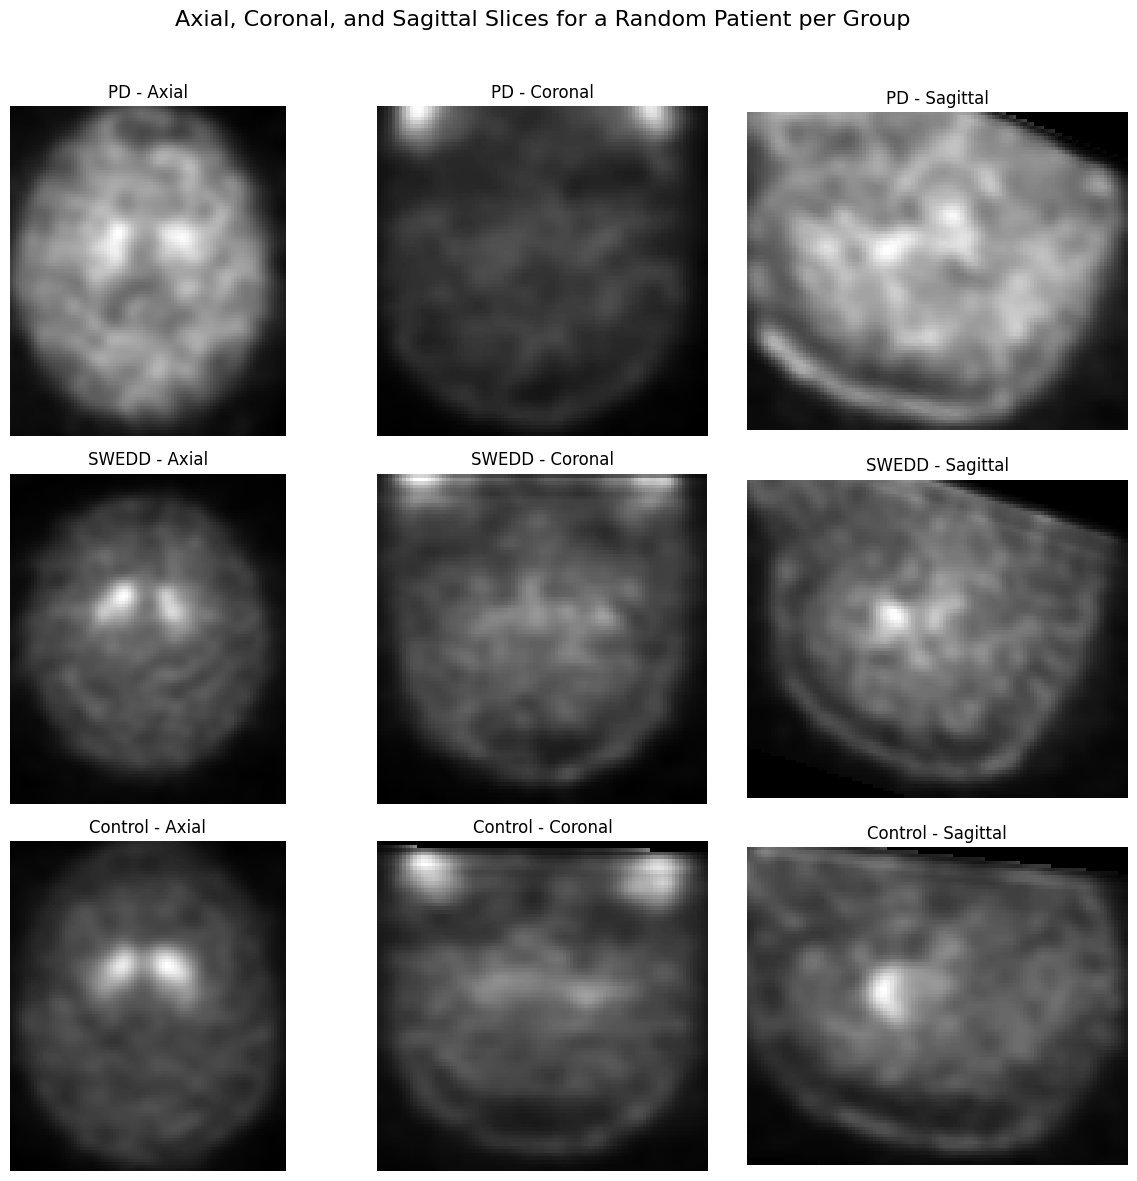

In [6]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}

# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue
    
    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")
    
    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)
    
    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")
    
    axial, coronal, sagittal = extract_slices(volume)
    
    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")
    
    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")
    
    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
# Cell 7: Data Preprocessing – Intensity Normalization & Volume Processing

import numpy as np

def intensity_normalization(volume):
    """
    Normalizes intensity values:
    - Truncates negative values (sets them to 0)
    - Applies min-max scaling to bring values between 0 and 1 per volume.
    
    :param volume: Input 3D volume as a numpy array.
    :return: Normalized volume.
    """
    volume = np.clip(volume, a_min=0, a_max=None)
    vol_min, vol_max = volume.min(), volume.max()
    if vol_max > vol_min:
        volume = (volume - vol_min) / (vol_max - vol_min)
    else:
        volume = volume - vol_min  # volume is constant
    return volume

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping while preserving aspect ratio.
    
    :param volume: Input 3D volume (numpy array) with shape (d, h, w).
    :param target_shape: Desired output shape (d_out, h_out, w_out).
    :return: Resized volume with shape target_shape.
    """
    current_shape = volume.shape
    resized = volume.copy()
    
    # For each dimension, either pad or crop to the target size
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            # Calculate padding sizes
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            # Center crop
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

# Example usage (for testing on one volume):
volume, _ = load_dicom(random_file)  # random_file selected previously
norm_vol = intensity_normalization(volume)
resized_vol = resize_volume(norm_vol)
print("Original shape:", volume.shape, "Resized shape:", resized_vol.shape)

Original shape: (91, 109, 91) Resized shape: (128, 128, 128)


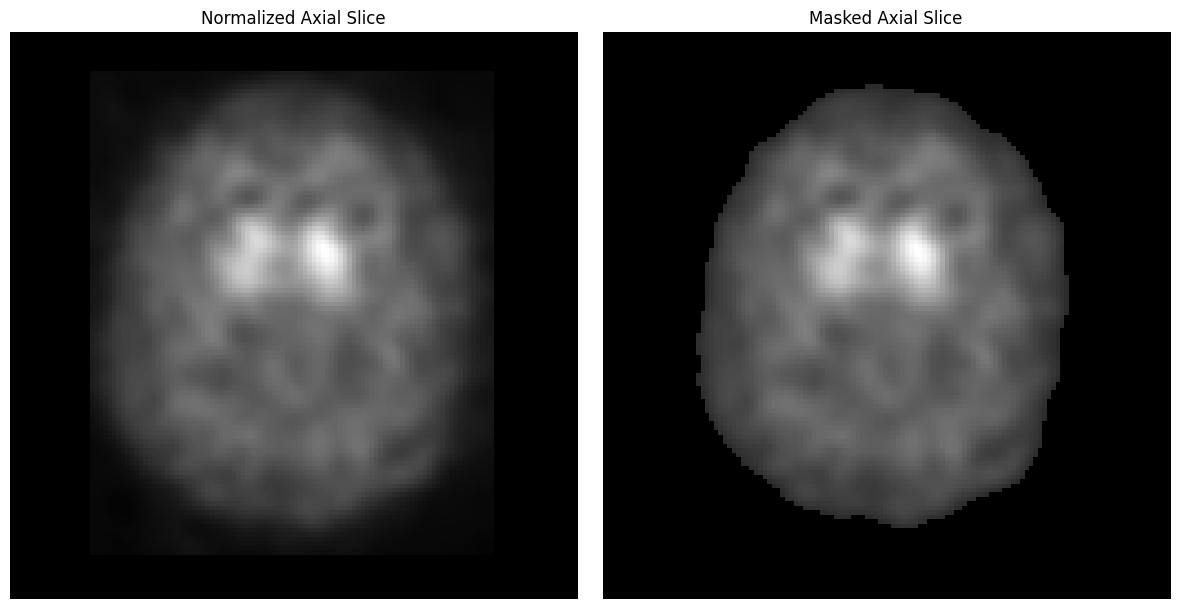

In [8]:
# Cell 8: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

# If not already defined, include the resize_volume function:
def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.
    
    :param volume: Input 3D volume as a numpy array.
    :param target_shape: Desired output shape (depth, height, width).
    :return: Resized volume.
    """
    resized = volume.copy()
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

def process_volume(volume, target_shape=(128, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling).
    2. Resizing to target_shape.
    3. Generating a brain mask via Otsu thresholding and 3D morphological closing.
    
    Returns:
      - norm_vol: The normalized and resized volume.
      - mask: The computed brain mask.
      - masked_vol: norm_vol multiplied by mask (i.e. non-brain regions zeroed out).
    """
    # 1. Intensity normalization (truncate negatives and min-max scale)
    volume = np.clip(volume, a_min=0, a_max=None)
    vmin, vmax = volume.min(), volume.max()
    if vmax > vmin:
        norm_vol = (volume - vmin) / (vmax - vmin)
    else:
        norm_vol = volume - vmin

    # 2. Resize the normalized volume to the target shape
    norm_vol = resize_volume(norm_vol, target_shape=target_shape)

    # 3. Compute brain mask using Otsu threshold and binary closing
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))  # using "footprint" as per current API
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(128,128,128))

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Cell 9: PyTorch Dataset and DataLoader with Progress Bar (Demonstration Subset)

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm  # Use tqdm for progress visualization

class DaTScanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initializes the dataset.
        :param dataframe: Pandas DataFrame with columns 'file_path' and 'label'.
        :param transform: Optional transform function.
        """
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]["file_path"]
        label = self.df.iloc[idx]["label"]
        volume, _ = load_dicom(file_path)
        # Process the volume using our unified function
        norm_vol, mask, masked_vol = process_volume(volume, target_shape=(128,128,128))
        # Add a channel dimension (expected shape: [1, D, H, W])
        masked_vol = np.expand_dims(masked_vol, axis=0)
        volume_tensor = torch.tensor(masked_vol, dtype=torch.float32)
        sample = {"volume": volume_tensor, "label": label}
        if self.transform:
            sample = self.transform(sample)
        return sample


Sample counts per group:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64


C:\Users\alexc\AppData\Local\Temp\ipykernel_30264\3113378977.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis")


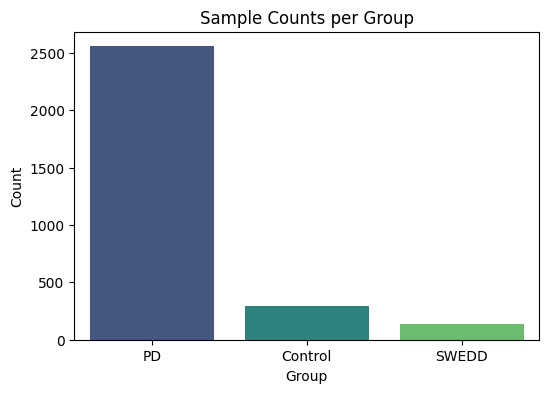


Intensity Statistics:
     label      mean  median       std
0  Control  0.044469     0.0  0.081917
1       PD  0.045744     0.0  0.086520
2    SWEDD  0.040196     0.0  0.080078


In [ ]:
# Cell 10: Exploratory Data Analysis (EDA) – Basic Statistics and Visualization

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming the validated DataFrame "df" (with 'file_path' and 'label' columns) is already loaded

# 1. Print and plot sample counts per group
group_counts = df["label"].value_counts()
print("Sample counts per group:")
print(group_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis")
plt.title("Sample Counts per Group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()

# 2. Compute intensity statistics for a subset of files per group
def compute_intensity_stats(dataframe, n_samples=10):
    stats_list = []
    for label in dataframe["label"].unique():
        group_df = dataframe[dataframe["label"] == label]
        sample_files = group_df.sample(min(n_samples, len(group_df)))["file_path"].tolist()
        intensities = []
        for file in sample_files:
            # Load the DICOM volume and process it (normalization, resizing, masking)
            vol, _ = load_dicom(file)
            norm_vol, _, _ = process_volume(vol, target_shape=(128, 128, 128))
            intensities.extend(norm_vol.flatten())
        stats_list.append({
            "label": label,
            "mean": np.mean(intensities),
            "median": np.median(intensities),
            "std": np.std(intensities)
        })
    return pd.DataFrame(stats_list)

intensity_stats = compute_intensity_stats(df, n_samples=10)
print("\nIntensity Statistics:")
print(intensity_stats)

# 3. Plot intensity distributions (using kernel density estimation) per group
plt.figure(figsize=(10, 6))
for label in df["label"].unique():
    group_df = df[df["label"] == label]
    sample_files = group_df.sample(min(5, len(group_df)))["file_path"].tolist()
    intensities = []
    for file in sample_files:
        vol, _ = load_dicom(file)
        norm_vol, _, _ = process_volume(vol, target_shape=(128, 128, 128))
        intensities.extend(norm_vol.flatten())
    sns.kdeplot(intensities, label=label)
plt.title("Intensity Distribution per Group")
plt.xlabel("Normalized Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# Cell 11: Modeling Pipeline – Define an Autoencoder Model Architecture

import torch
import torch.nn as nn

class Conv3DAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Conv3DAutoencoder, self).__init__()
        # Encoder: Three convolutional layers with downsampling (stride=2)
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # 128 -> 64
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        # Flatten layer and bottleneck
        self.flatten = nn.Flatten()
        # The flattened dimension is 64 channels * 16 * 16 * 16 voxels
        self.fc1 = nn.Linear(64 * 16 * 16 * 16, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64 * 16 * 16 * 16)
        # Decoder: Transposed convolutions to upsample back to original shape
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Scale outputs between 0 and 1
        )
    
    def forward(self, x):
        x_enc = self.encoder(x)
        x_flat = self.flatten(x_enc)
        latent = self.fc1(x_flat)
        x_de_flat = self.fc2(latent)
        # Reshape to match decoder input dimensions: [batch, 64, 16, 16, 16]
        x_de = x_de_flat.view(-1, 64, 16, 16, 16)
        x_recon = self.decoder(x_de)
        return x_recon, latent

# Test the model architecture with a dummy input
model = Conv3DAutoencoder(latent_dim=128)
dummy_input = torch.randn(1, 1, 128, 128, 128)  # Batch size 1
recon, latent = model(dummy_input)
print("Reconstructed output shape:", recon.shape)
print("Latent vector shape:", latent.shape)